In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-and-real-news-dataset/True.csv
/kaggle/input/fake-and-real-news-dataset/Fake.csv


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
import nltk
import re
import gensim
# from nltk.stem.snowball import SnowballStemmer
from gensim.parsing.preprocessing import remove_stopwords
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud

import tensorflow
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense


In [4]:
truedf = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/True.csv')
fakedf = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/Fake.csv')

In [5]:
truedf.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [6]:
fakedf.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [7]:
truedf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [8]:

fakedf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [9]:
truedf.drop_duplicates(inplace=True)

In [10]:
fakedf.drop_duplicates(inplace=True)

In [11]:
#creating class labels

fakedf['class'] = 0
truedf['class'] = 1

## **Data Visulaization:**

Creating Wordcloud for the most frequent words in Fake and True Datasets.

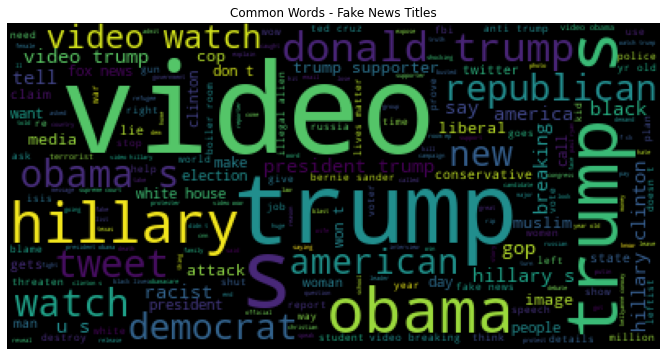

In [12]:
#WordCloud visualization for fake words.

fake_words=''

for headline in fakedf['title']:
    text = headline.lower()
    fake_words= fake_words + text + ' '
    
fake_words = remove_stopwords(fake_words)
fake_wordcloud = WordCloud().generate(fake_words)

plt.figure(figsize=(12,6))
plt.title("Common Words - Fake News Titles")
plt.imshow(fake_wordcloud)
plt.axis('off');

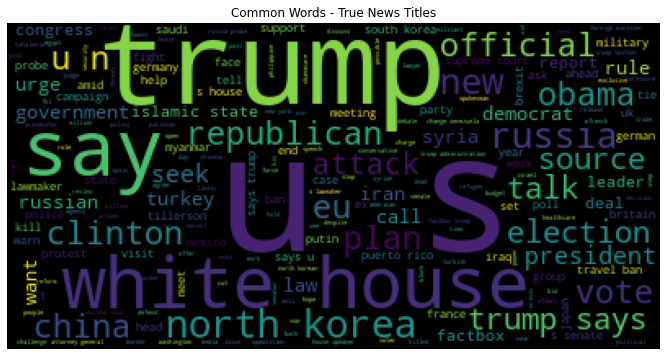

In [13]:
true_words=''

for headline in truedf['title']:
    text = headline.lower()
    true_words= true_words + text + ' '
    
true_words = remove_stopwords(true_words)
true_wordcloud = WordCloud().generate(true_words)

plt.figure(figsize=(12,6))
plt.title("Common Words - True News Titles")
plt.imshow(true_wordcloud)
plt.axis('off');

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


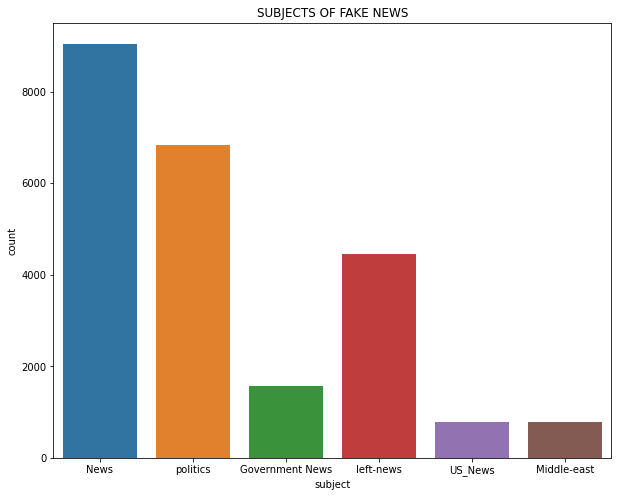

In [14]:
plt.figure(figsize=(10,8))
sns.countplot('subject', data= fakedf)
plt.title('SUBJECTS OF FAKE NEWS');

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


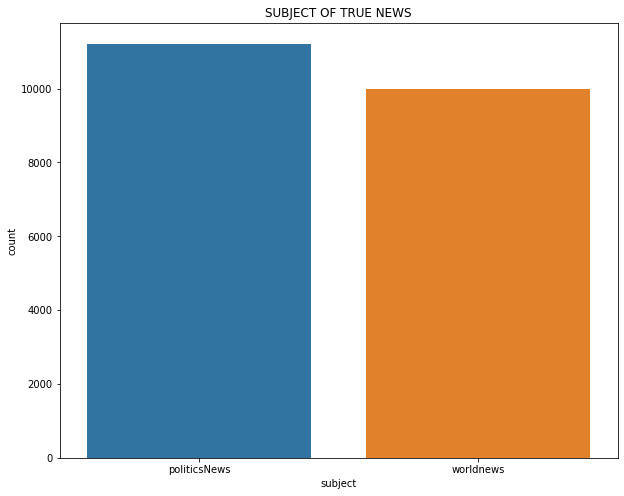

In [15]:
plt.figure(figsize=(10,8))
sns.countplot('subject', data=truedf)
plt.title('SUBJECT OF TRUE NEWS');

In [16]:
data = pd.concat([fakedf,truedf],axis=0)
data.head()

,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44689 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44689 non-null  object
 1   text     44689 non-null  object
 2   subject  44689 non-null  object
 3   date     44689 non-null  object
 4   class    44689 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.0+ MB


In [18]:
data = data.reset_index(drop=True)
data = data.drop('date',axis=1)
data.head()

,title,text,subject,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,0


In [19]:
data.tail()

,title,text,subject,class
44684,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,1
44685,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,1
44686,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,1
44687,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,1
44688,Indonesia to buy $1.14 billion worth of Russia...,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,worldnews,1


## **Text Preprocessing**

In [20]:
def remove_shortforms(phrase):
    phrase= re.sub(r"won't","will not", phrase)
    phrase= re.sub(r"can't","can not", phrase)
    #general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def remove_special_char(text):
    text = re.sub('[^A-Za-z0-9]+'," ",text)
    return text

def remove_wordswithnum(text):
    text= re.sub("\S*\d\S*", "", text).strip()
    return text

def lowercase(text):
    text= text.lower()
    return text

def remove_stop_words(text):
    text= remove_stopwords(text)
    return text

# st= SnowballStemmer(language='english')
# def stemming(text):
#     r=[]
#     for word in text:
#         a=st.stem(word)
#         r.append(a)
#     return r

def listToString(s):
    str1=" "
    return(str1.join(s))

In [21]:
start_time = time.time()
for i in range(len(data['text'])):
    data['text'][i] = remove_shortforms(data['text'][i])
    data['text'][i] = remove_special_char(data['text'][i])
    data['text'][i] = remove_wordswithnum(data['text'][i])
    data['text'][i] = lowercase(data['text'][i])
    data['text'][i] = remove_stop_words(data['text'][i])
#     text = data['text'][i]
#     text = text.split()
#     data['text'][i] = stemming(text)
#     s = data['text'][i]
#     data['text'][i] = listToString(s)
print("Time taken to preprocess : ",time.time()-start_time," seconds")
    
    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

Time taken to preprocess :  161.80004119873047  seconds


In [22]:
start_time = time.time()
for i in range(len(data['title'])):
    data['title'][i] = remove_shortforms(data['title'][i])
    data['title'][i] = remove_special_char(data['title'][i])
    data['title'][i] = remove_wordswithnum(data['title'][i])
    data['title'][i] = lowercase(data['title'][i])
    data['title'][i] = remove_stopwords(data['title'][i])
#     text = data['title'][i]
#     text = text.split()
#     data['title'][i] = stemming(text)
#     s = data['title'][i]
#     data['title'][i] = listToString(s)
print("Time taken to preprocess : ",time.time()-start_time," seconds")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

Time taken to preprocess :  115.19995045661926  seconds


In [23]:
start_time = time.time()
for i in range(len(data['subject'])):
    data['subject'][i] = remove_shortforms(data['subject'][i])
    data['subject'][i] = remove_special_char(data['subject'][i])
    data['subject'][i] = remove_wordswithnum(data['subject'][i])
    data['subject'][i] = lowercase(data['subject'][i])
    data['subject'][i] = remove_stopwords(data['subject'][i])
#     text = data['subject'][i]
#     text = text.split()
#     data['subject'][i] = stemming(text)
#     s = data['subject'][i]
#     data['subject'][i] = listToString(s)
print("Time taken to preprocess : ",time.time()-start_time," seconds")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

Time taken to preprocess :  105.1416654586792  seconds


In [24]:
data.head()

,title,text,subject,class
0,donald trump sends embarrassing new year s eve...,donald trump couldn t wish americans happy new...,news,0
1,drunk bragging trump staffer started russian c...,house intelligence committee chairman devin nu...,news,0
2,sheriff david clarke internet joke threatening...,friday revealed milwaukee sheriff david clarke...,news,0
3,trump obsessed obama s coded website images,christmas day donald trump announced work foll...,news,0
4,pope francis called donald trump christmas speech,pope francis annual christmas day message rebu...,news,0


In [25]:
Combined_text = [None] * len(data['text'])
for i in range(len(data['title'])):
    Combined_text[i]= data['text'][i] + " " + data['title'][i] + " " + data['subject'][i]

data['combined_text'] = Combined_text

In [26]:
#dropping the unnecessary columns
data = pd.DataFrame.drop(data,columns=['title','text','subject'],axis=1)
data.head()

,class,combined_text
0,0,donald trump couldn t wish americans happy new...
1,0,house intelligence committee chairman devin nu...
2,0,friday revealed milwaukee sheriff david clarke...
3,0,christmas day donald trump announced work foll...
4,0,pope francis annual christmas day message rebu...


## **Text Vectorization**

***WORD2VEC VECTORIZATION*** :

In [27]:
y = data['class'].values
#Converting X to format acceptable by gensim
X = []
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in data["combined_text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)


In [28]:
w2v = gensim.models.Word2Vec(sentences=X,vector_size = 100, window=5,min_count=1)

***EXPLORING THE VECTORS CREATED*** :

In [29]:
w2v.wv['trump']

array([-1.666319  ,  1.3620644 ,  0.22789916,  2.1416326 ,  0.6213692 ,
        0.44859913,  1.6247947 ,  1.1120683 ,  1.558505  , -0.46697327,
       -2.1590617 , -0.06346761, -0.45487225,  1.0341548 ,  0.75469   ,
        0.83042425,  0.39993522,  1.992001  ,  0.27551243,  1.0280789 ,
        0.1357373 ,  0.9504355 ,  2.251712  ,  0.9071313 , -0.01229091,
       -0.98244375, -2.617529  ,  0.24828203,  0.91584814, -2.5789654 ,
       -3.0879798 ,  0.98228985,  1.836785  ,  2.8132753 , -1.9979789 ,
       -1.9737284 , -0.5634615 , -0.02898626,  0.70941406,  1.5696853 ,
       -0.04804529,  1.5915607 , -0.6136982 , -0.8758894 ,  2.6462193 ,
        1.0618578 , -0.1591126 ,  1.4975199 , -1.0705265 ,  1.5841745 ,
       -1.5513325 ,  0.42301542, -1.7931094 , -0.84751296,  0.47588733,
        0.5648217 ,  1.0712488 ,  0.27189043, -1.5091966 ,  0.3828272 ,
        0.78028476, -1.7321353 , -2.0529785 , -2.3734205 ,  0.6998086 ,
        0.15315978,  0.94188476, -2.2905636 , -1.2056843 ,  0.02

In [30]:
w2v.wv.most_similar("trump")

[('elect', 0.6446213722229004),
 ('cruz', 0.5011091232299805),
 ('obama', 0.4967404007911682),
 ('candidacy', 0.4966854751110077),
 ('incoming', 0.4892250895500183),
 ('president', 0.48160654306411743),
 ('romney', 0.4757687747478485),
 ('pence', 0.4709472954273224),
 ('realdonaidtromp', 0.46438953280448914),
 ('clinton', 0.4544208347797394)]

In [31]:
w2v.wv.most_similar("pope")

[('francis', 0.8839386105537415),
 ('vatican', 0.7280823588371277),
 ('pontiff', 0.7232911586761475),
 ('papal', 0.6266325116157532),
 ('angeli', 0.619498074054718),
 ('xiii', 0.593454122543335),
 ('encyclical', 0.5515926480293274),
 ('implicitly', 0.5403127074241638),
 ('radiance', 0.5223581790924072),
 ('homily', 0.5188863277435303)]

In [32]:
len(w2v.wv.key_to_index)

106000

## **LSTM model building**

In [34]:
# Tokenizing Text -> Repsesenting each word by a number
# Mapping of orginal word to number is preserved in word_index property of tokenizer

#Tokenized applies basic processing like changing it yo lower case, explicitely setting that as False

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

In [35]:
X[0][:10] #the first ten words of the first news is represented as :

[13, 1, 1136, 2185, 93, 1380, 7, 16, 461, 354]

In [36]:
word_index = tokenizer.word_index

In [37]:
#word_index 
#list of all the words with their original numerical mappingd is stored un the word_index

We can pass numerical representation of words into neural network.

We can use Many-To-One (Sequence-To-Word) Model of RNN, as we have many words in news as input and one output ie Probability of being Real.

For Many-To-One model, lets use a fixed size input.

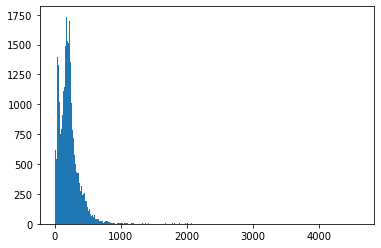

In [38]:
# For determining size of input...

# Making histogram for no of words in news shows that most news article are under 700 words.
# Lets keep each news small and truncate all news to 700 while tokenizing
plt.hist([len(x) for x in X], bins=500)
plt.show()

# It's heavily skewed.

In [39]:
nos = np.array([len(x) for x in X])
len(nos[nos  < 750])

44164

In [40]:
#Lets keep all news to 750, add padding to news with less than 750 words and truncating long ones
maxlen = 750 

#Making all news of size maxlen defined above
X = pad_sequences(X, maxlen=maxlen)

In [42]:
vocab_size = len(tokenizer.word_index) + 1

In [45]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model,vocab):
    #total vocabulary size plus 0 for unknown words
    vocab_size= len(vocab)+1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size,100))
    
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i  in vocab.items():
        weight_matrix[i] = model.wv[word]
    return weight_matrix

We Create a matrix of mapping between word-index and vectors. We use this as weights in embedding layer

Embedding layer accepts numerical-token of word and outputs corresponding vercor to inner layer.

It sends vector of zeros to next layer for unknown words which would be tokenized to 0.

Input length of Embedding Layer is the length of each news (700 now due to padding and truncating)

In [101]:
embedding_vectors = get_weight_matrix(w2v,word_index)

In [102]:
#Define Neural Network

model = Sequential()

#Non-Trainable embedding layer

model.add(Embedding(vocab_size, output_dim = 100, weights = [embedding_vectors], input_length = maxlen, trainable =False))
#LSTM
model.add(LSTM(units=128))
model.add(Dense(1,activation = 'sigmoid'))
model.compile(optimizer='adam', loss= 'binary_crossentropy',metrics=['accuracy'])

del embedding_vectors

In [103]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 750, 100)          10600100  
_________________________________________________________________
lstm_8 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 10,717,477
Trainable params: 117,377
Non-trainable params: 10,600,100
_________________________________________________________________


## **Train Test Split**

In [104]:
from sklearn.model_selection import train_test_split
y= data['class'].values
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

## **Model Training and Testing**

In [105]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=3)

Epoch 1/3
838/838 [==============================] - 34s 39ms/step - loss: 0.0053 - accuracy: 0.9988 - val_loss: 5.2171e-05 - val_accuracy: 1.0000
Epoch 2/3
838/838 [==============================] - 32s 38ms/step - loss: 2.5825e-05 - accuracy: 1.0000 - val_loss: 1.5986e-05 - val_accuracy: 1.0000
Epoch 3/3
838/838 [==============================] - 32s 39ms/step - loss: 9.8445e-06 - accuracy: 1.0000 - val_loss: 7.9525e-06 - val_accuracy: 1.0000


In [106]:
#Prediction is in probability of news being real, so converting into classes
# Class 0 (Fake) if predicted prob < 0.5, else class 1 (Real)
y_pred = (model.predict(X_test) >= 0.5).astype("int")

In [107]:
from sklearn.metrics import r2_score
r2_score(y_test,y_pred)

1.0

In [108]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5943
           1       1.00      1.00      1.00      5230

    accuracy                           1.00     11173
   macro avg       1.00      1.00      1.00     11173
weighted avg       1.00      1.00      1.00     11173



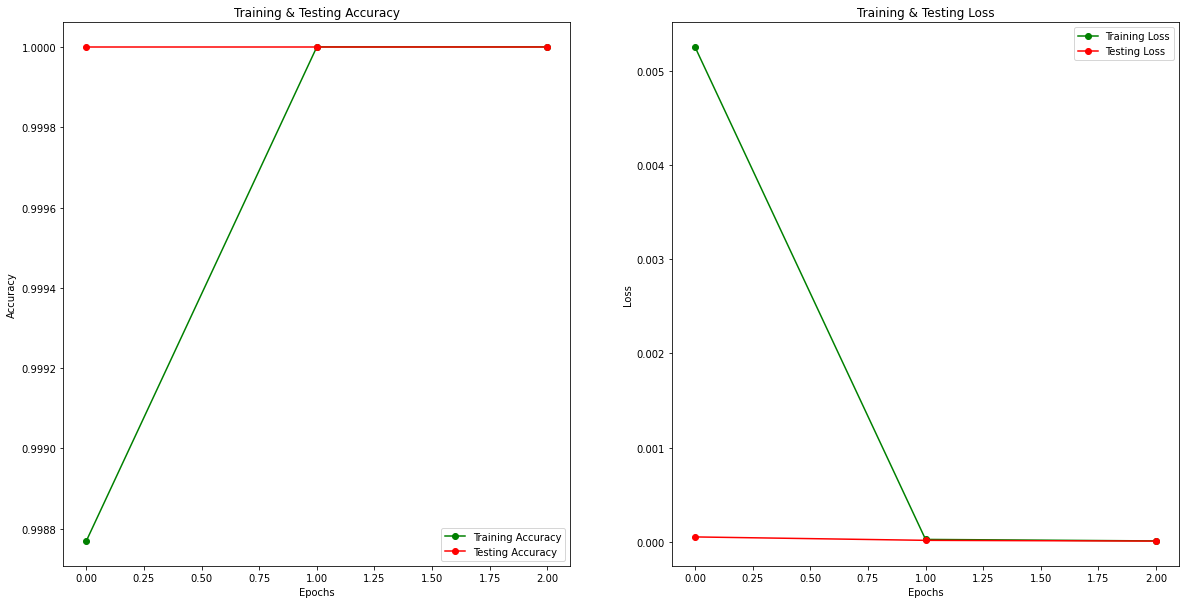

In [109]:
epochs = [i for i in range(3)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

WE ARE GETTING AN ACCURACY OF 100% 